<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/AIChallenge002_%E5%AD%A6%E7%BF%92%E3%81%A8%E8%AD%98%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備
## 0.1 ハードウェアアクセラレータの設定

1. [「AIChallenge001-画像の収集」を済ませておく](https://github.com/aquapathos/BasicAI/blob/master/AIChallenge001_%E7%94%BB%E5%83%8F%E3%81%AE%E5%8F%8E%E9%9B%86.ipynb)

2. [「ランタイム」メニューを開く]()
3. [「ランタイムのタイプを変更」をクリック]()
4. [[「ハードウェアアクセラレータ」で **GPU** を選択し，「保存」]()

<font color='green'>※ Google Colabは無料サービスを維持するため、利用者が多すぎるため GPU が使えない場合があります。その場合は時間がかかりますが、CPUでも実験は可能です。    
※ 同様に、複数セッションが許可されない場合があります。「セッションが多すぎます」と出た場合は他の起動中ランタイムを終了させてください。</font>


# 1. Google Drive をマウント
AIChallenge001 で保存した画像データを使うために Google Drive に接続します。

1. [次のセルを実行する]()
2. [リンクと入力フィールドが表示されるのでリンクをクリック]()
3. [アクセスリクエストを許可するとアクセス用のコードが表示されるのでコピー]()
4. [Enter your authorization code: フィールドに貼り付けて Enter]()
5. [ファイル一覧エリアで「更新」をクリック]()

<img width="390" alt="googlecolab" src="https://user-images.githubusercontent.com/5820803/94802343-739cff00-0422-11eb-8c0d-affa919f8e58.png">

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ２．　画像の読み込みと表示
##  2.1 関数定義
001 で使ったプログラムと同じです。　[次のセルを実行]() 



In [ ]:
!pip -q install japanize-matplotlib
import pickle
import os,math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib

# tensorflow2.x を前提としている。1.x の場合、tensorflow.keras を ただの keras に変える。
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Input, Activation, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger,TensorBoard
import tensorflow as tf

SIZE = 128

# 変数の宣言
DATASIZE = SIZE *  SIZE * 3
    
# pickle 形式で保存された画像データの読み込み
def loadCategoryImages(fname, folder = "."):
    f = open(folder+"/"+fname,'rb')
    cat = pickle.load(f)
    f.close
    return cat

# 画像データの表示
# start番からnpic枚表示する関数を定義
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showimg(images, start = 0, npic = 48):
    n = npic if len(images) >= start+npic else len(images) - start
    plt.figure(figsize=(8,7.5*(math.ceil(n/8))/6),dpi=150)
    i = 0
    while True:
        if i < n :  
            plt.subplot((n-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[start+i][:,:,::-1])
            plt.title("{}".format(start+i))
            i += 1
        else:
            break

## 2.2 画像データの読み込みと内容確認

先に収集した画像データを読み込み、一部を表示して内容が同じか確認しておきます。　[次のセルを実行]() 

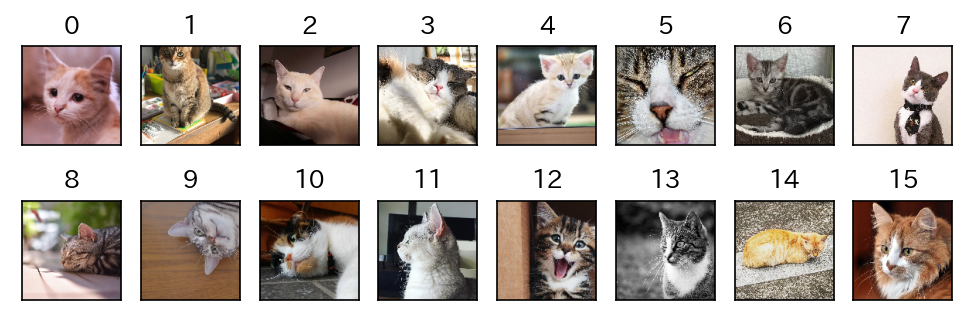

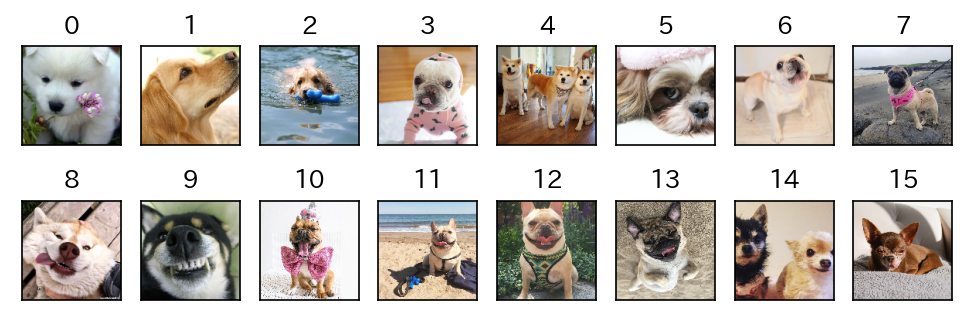

In [ ]:
GFOLDER = "drive/MyDrive/LDATA"  # データ保存用のフォルダ名
c0img = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
c1img = loadCategoryImages("イヌ.pkl", folder=GFOLDER)
showimg(c0img,0,16)
showimg(c1img,0,16)

# 3. 学習と認識の実験

## 3.1 学習モデル

![3つのモデル](https://github.com/aquapathos/pictures/blob/gh-pages/BasicAIFig004.png?raw=true)

つぎの３種のニューラルネットワークモデルで学習と識別の実権を試みることにします。

1. **model1**　中間層なしで、入力画像とネコ・イヌ２つのカテゴリーに対応する２つのノードを全結合し、**softmax** (†) で１つに絞る。
2. **model2**　入力と出力は model1 と同じ。1024ノードの中間層を設けて、全結合
3. **model3**　畳み込み(32)、畳み込み(64)、プーリング、畳み込み(128)、プーリング、、畳み込み(64)，平坦化，全結合(1024) 、全結合(64) の構成の　CNN（畳み込みニューラルネットワーク）

model 3 の畳み込みのカーネルサイズ（フィルタマトリクスの大きさ）はすべて （3,3）とし、プーリングはすベてサイズ２の max pooling とします。

(†) **softmax** 出力のうち、最も値の大きいものがほぼ１，ほかはほぼ０となるように変換する関数。

## 3.2 学習データの作成

画像データを訓練用とテスト用に分割し，学習用のデータをXtrainとXtestに分割します．

[次のセルを実行]() 

In [ ]:
#  変数の初期化
def make_dataset(catalist):
    # catlist で与えられた画像データのリストから訓練用とテスト用のデータを作成し，
    # Xtrain (訓練用画像), ytrain（訓練例の正解)，Xtrain (テスト用画像), ytrain（テスト画像に対する)，NDATA（1カテゴリ当たりのデータ数）
    # 学習に用いるデータ数を、一番データ数の少ないカテゴリのデータ数に合わせる
    mindata = np.inf # 十分大きな数
    for cat in catalist:
        if len(cat) < mindata:
            mindata = len(cat)
    # ここに到達した時点で、mindata にはもっともデータ数の少ないカテゴリのデータ数が入っている
    NDATA = mindata
    threer = mindata%3
    NDATA = mindata - threer  #  個数を３の倍数となるよう調整

    Xtrain,Xtest = [],[]  # 入力画像のリスト
    ytrain,ytest = [],[]  #  ラベルのリスト
    label = 0
    for cimgs in catalist:
        Xtrain = Xtrain + cimgs[0:int(2*NDATA/3)]
        ytrain = ytrain + [label]*int(2*NDATA/3)
        Xtest = Xtest + cimgs[int(2*NDATA/3):NDATA]
        ytest = ytest + [label]*int(NDATA/3)
        label +=1
    return Xtrain,ytrain,Xtest,ytest,NDATA

次のプログラムで，**CATALIST = [c1img,c2img]** の部分で認識対象となるカテゴリの画像データを指定する．カテゴリは２つである必要はなく，例えば，４つならば，

**CATALIST = [c1img,c2img,c3img,c4img]**   

等としてください．　[次のセルを実行]() 

In [ ]:
catnamelist = ['ネコ','イヌ']
CATALIST = [c0img,c1img] # c0img:ネコ，c1img：イヌ
CLASSES= len(CATALIST)  #  カテゴリ数　　
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytrain,ytest)

カテゴリ数 2   1カテゴリ当たりのデータ数 81
訓練用 108 テスト用 54  　データ総数 162
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


（補足）　データ数は一番データの少ないカテゴリに合わせています。それぞれのデータのうち３分の２を訓練データ、残りの３分の１をテストデータとしています。　

# model1  全結合２層ネットワーク

## モデル定義
[以下のセルを順に実行していってください．]() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 98306     
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
_________________________________________________________________


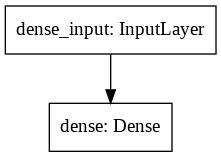

In [ ]:
# Model 1
model1 = Sequential([
    Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,))
])

model1.summary()

from IPython.display import Image, display_png
#学習モデル図の作成
plot_model(model1, to_file='model1.png')
display_png(Image('model1.png'))

## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model1

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら5エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss') # 誤差
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy') #  正解率
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

### 結果の意味
- <font color='red'> **loss**</font> : 教師データと結果の差の誤差   
- <font color='red'> **accuracy**</font> : 正解率     
- <font color='red'> **Epoch**</font> : このプログラムでは全訓練データを１度ずつ使って誤差を計算し、ノードの重みを修正することが１エポックで、それを１００回繰り返しています。

学習中に出力されている誤差と正解率は訓練データに対するものです。通常は誤差は０、正解率は１（100%)に近づいていきます。

## 訓練データに対する識別結果

In [ ]:
# 識別結果
def recognitionResult(model, Xdata, ydata, catnamelist=catnamelist):
    ndata = len(Xdata) # データ数
    predictT = model.predict(Xdata)
    predictT = [np.argmax(n1)  for n1 in predictT]
    NCAT = len(CATALIST) # カテゴリ数
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    Error = []
    for i in range(ndata):
        ct1[ydata[i],predictT[i]] += 1
        if ydata[i] != predictT[i]:
            Error.append([i,ydata[i],predictT[i]])
    print("誤認識データ（[データ番号, 正解, 認識結果]）\n {0} \n　正解率={1:5.1f}　誤り率＝{2:5.1f} %\n".format(Error,100*(ndata-len(Error))/ndata,100*len(Error)/ndata))
    print("正解カテゴリに対する認識結果と正解率")
    crossT1 = pd.concat([pd.DataFrame(catnamelist,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=catnamelist)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.round(1000*crossT1[cat][i]/ndata*NCAT)/10 for i,cat in enumerate(catnamelist)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')

    return Error, crossT1

# 認識間違いの表示
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showEimg(errlist, images):
    last = len(errlist) 
    plt.figure(figsize=(8,7.5*(math.ceil(last/8))/6),dpi=150)
    for i in range(last):
            plt.subplot((last-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[errlist[i][0]][:,:,::-1])
            plt.xlabel("{}→{}".format(catnamelist[errlist[i][1]],
                                catnamelist[errlist[i][2]])) 

In [ ]:
import pandas as pd



TrainError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[18, 0, 1], [22, 0, 1], [26, 0, 1], [68, 1, 0], [72, 1, 0], [106, 1, 0]] 
　正解率= 94.4　誤り率＝  5.6 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,51,3,94.4
イヌ,3,51,94.4


誤認識したデータ


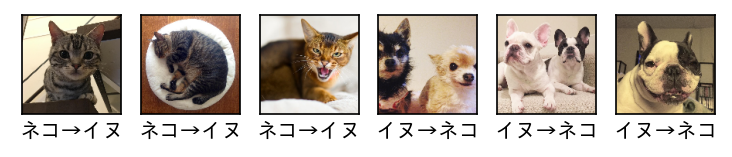

In [ ]:


# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

### 補足説明

- 結果は訓練データによって変わりますし、モデルの重みの初期値がランダムに設定されるため、同じ訓練データでも、最終的な正解率や何をご認識するかは変わります。

- 訓練データに対する正解率は一般に高くなるはずで、１００％正解、誤認識０ということもあります。

- <font color='red'>一般にlossは単調減少、accuracy は単調増加するのが普通ですが、大きく上下した結果、正解率があまり上がらずに学習が終了することがあります。その場合はモデル定義のところからやり直してください。</font>

## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model1,Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [5, 0, 1], [8, 0, 1], [9, 0, 1], [10, 0, 1], [13, 0, 1], [14, 0, 1], [19, 0, 1], [28, 1, 0], [30, 1, 0], [31, 1, 0], [32, 1, 0], [33, 1, 0], [37, 1, 0], [39, 1, 0], [41, 1, 0], [42, 1, 0], [43, 1, 0], [46, 1, 0], [47, 1, 0], [49, 1, 0], [50, 1, 0]] 
　正解率= 57.4　誤り率＝ 42.6 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,18,9,66.7
イヌ,14,13,48.1


-  この実験では訓練データが少ないのであまり高い正解率は望めません。  
-  ２カテゴリなので、デタラメに答えても正解率は５０％前後となるはずです。model1 では、それに毛の生えた程度の結果となるのが普通です。

In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# model 2　　３層全結合バックプロパゲーションネットワーク（中間層1024ノード）

## モデル定義

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              50332672  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 50,334,722
Trainable params: 50,334,722
Non-trainable params: 0
_________________________________________________________________


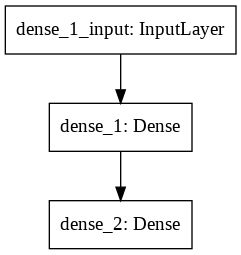

In [ ]:
# Model 2

model2 = Sequential([
    Dense(1024,activation='relu',input_shape=(DATASIZE,)),
    Dense(CLASSES, activation='softmax')])

model2.summary()

#学習モデル図の作成
plot_model(model2, to_file='model2.png')
display_png(Image('model2.png'))

## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model2

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model2,Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,54,0,100.0
イヌ,0,54,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model2,Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [3, 0, 1], [5, 0, 1], [8, 0, 1], [10, 0, 1], [12, 0, 1], [13, 0, 1], [15, 0, 1], [17, 0, 1], [18, 0, 1], [19, 0, 1], [26, 0, 1], [28, 1, 0], [30, 1, 0], [33, 1, 0], [37, 1, 0], [39, 1, 0], [43, 1, 0], [47, 1, 0], [49, 1, 0], [50, 1, 0]] 
　正解率= 59.3　誤り率＝ 40.7 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,14,13,51.9
イヌ,9,18,66.7


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# model 3  CNN(畳み込みネットワーク）

## モデル定義

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

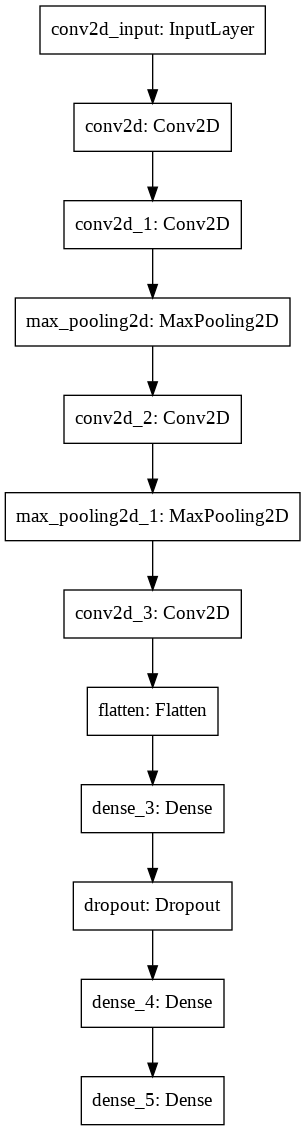

In [ ]:
# Model ３

model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # 64 x 64 x 64
    Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  #  32 x 32 x 128
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(CLASSES, activation='softmax')])

model3.summary()

#学習モデル図の作成
plot_model(model3, to_file='model3.png')
display_png(Image('model3.png'))


## ニューラルネットワークの設定と学習の実行

In [ ]:
model = model3

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

### 学習過程のグラフ化

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model3, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,54,0,100.0
イヌ,0,54,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(model3, Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [2, 0, 1], [3, 0, 1], [5, 0, 1], [8, 0, 1], [10, 0, 1], [13, 0, 1], [17, 0, 1], [18, 0, 1], [19, 0, 1], [20, 0, 1], [26, 0, 1], [28, 1, 0], [30, 1, 0], [32, 1, 0], [33, 1, 0], [37, 1, 0], [39, 1, 0], [41, 1, 0], [43, 1, 0], [47, 1, 0], [49, 1, 0], [50, 1, 0]] 
　正解率= 55.6　誤り率＝ 44.4 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,正解率
正解カテゴリ,,,
ネコ,14,13,51.9
イヌ,11,16,59.3


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ
else:
  print("誤認識はありません")

# ネコとカメ

イヌの代わりにカメで同じ実験をやってみましょう．

In [ ]:
# c0img = loadCategoryImages("ネコ.pkl", folder=GFOLDER)
c2img = loadCategoryImages("カメ.pkl", folder=GFOLDER)
showimg(c0img,0,16)
showimg(c2img,0,16)

In [ ]:
catnamelist = ['ネコ','カメ']
CATALIST=[c0img,c2img] # c0img:ネコ, c2img:カメ

# 訓練用とテスト用に分割
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytrain,ytest)

カテゴリ数 2   1カテゴリ当たりのデータ数 102
訓練用 136 テスト用 68  　データ総数 204
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## model1

In [ ]:
# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　2　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential([
    Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,))
])

model = model1
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
from matplotlib import cm
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss') # 誤差
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy') #  正解率
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
def recognitionResult(model, Xdata, ydata, catnamelist=catnamelist):
    ndata = len(Xdata) # データ数
    predictT = model.predict(Xdata)
    predictT = [np.argmax(n1)  for n1 in predictT]
    NCAT = len(CATALIST) # カテゴリ数
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    Error = []
    for i in range(ndata):
        ct1[ydata[i],predictT[i]] += 1
        if ydata[i] != predictT[i]:
            Error.append([i,ydata[i],predictT[i]])
    print("誤認識データ（[データ番号, 正解, 認識結果]）\n {0} \n　正解率={1:5.1f}　誤り率＝{2:5.1f} %\n".format(Error,100*(ndata-len(Error))/ndata,100*len(Error)/ndata))
    print("正解カテゴリに対する認識結果と正解率")
    crossT1 = pd.concat([pd.DataFrame(catnamelist,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=catnamelist)],axis=1)
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.round(1000*crossT1[cat][i]/ndata*NCAT)/10 for i,cat in enumerate(catnamelist)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')

    return Error, crossT1

# 認識間違いの表示
plt.rcParams['figure.figsize'] = (12.0, 7.0)
def showEimg(errlist, images):
    last = len(errlist) 
    plt.figure(figsize=(8,7.5*(math.ceil(last/8))/6),dpi=150)
    for i in range(last):
            plt.subplot((last-1)//8+1,8,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(images[errlist[i][0]][:,:,::-1])
            plt.xlabel("{}→{}".format(catnamelist[errlist[i][1]],
                                catnamelist[errlist[i][2]])) 

In [ ]:
TrainError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[6, 0, 1], [8, 0, 1], [9, 0, 1], [20, 0, 1], [26, 0, 1], [34, 0, 1], [44, 0, 1], [51, 0, 1], [53, 0, 1], [66, 0, 1], [81, 1, 0], [85, 1, 0], [92, 1, 0], [119, 1, 0], [128, 1, 0]] 
　正解率= 89.0　誤り率＝ 11.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,58,10,85.3
カメ,5,63,92.6


誤認識したデータ


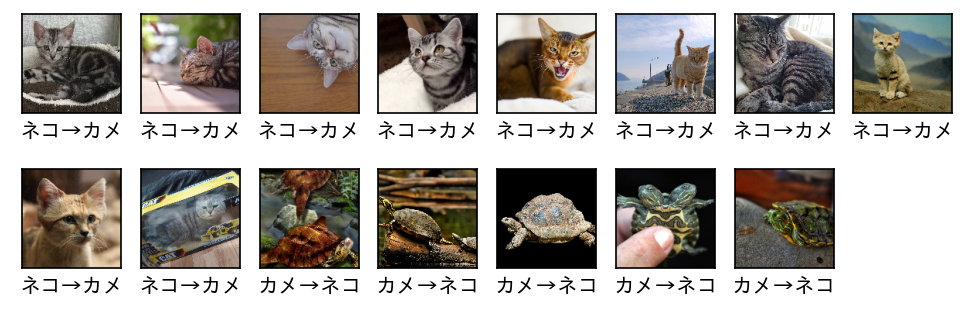

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [5, 0, 1], [7, 0, 1], [12, 0, 1], [15, 0, 1], [17, 0, 1], [23, 0, 1], [26, 0, 1], [28, 0, 1], [29, 0, 1], [32, 0, 1], [35, 1, 0], [40, 1, 0], [43, 1, 0], [50, 1, 0], [51, 1, 0], [52, 1, 0], [63, 1, 0]] 
　正解率= 73.5　誤り率＝ 26.5 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,23,11,67.6
カメ,7,27,79.4


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## model2

In [ ]:
# Model 2

model2 = Sequential([
    Dense(1024,activation='relu',input_shape=(DATASIZE,)),
    Dense(CLASSES, activation='softmax')
])

model = model2
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model2, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[72, 1, 0], [74, 1, 0], [77, 1, 0], [81, 1, 0], [85, 1, 0], [86, 1, 0], [90, 1, 0], [91, 1, 0], [93, 1, 0], [96, 1, 0], [100, 1, 0], [102, 1, 0], [103, 1, 0], [110, 1, 0], [111, 1, 0], [115, 1, 0], [116, 1, 0], [117, 1, 0], [119, 1, 0], [123, 1, 0], [125, 1, 0], [128, 1, 0], [131, 1, 0], [132, 1, 0]] 
　正解率= 82.4　誤り率＝ 17.6 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,68,0,100.0
カメ,24,44,64.7


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model2, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [5, 0, 1], [12, 0, 1], [17, 0, 1], [23, 0, 1], [28, 0, 1], [35, 1, 0], [37, 1, 0], [38, 1, 0], [40, 1, 0], [42, 1, 0], [43, 1, 0], [45, 1, 0], [47, 1, 0], [48, 1, 0], [50, 1, 0], [51, 1, 0], [52, 1, 0], [53, 1, 0], [54, 1, 0], [58, 1, 0], [59, 1, 0], [60, 1, 0], [63, 1, 0], [65, 1, 0], [67, 1, 0]] 
　正解率= 61.8　誤り率＝ 38.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,28,6,82.4
カメ,20,14,41.2


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

# model3

In [ ]:
# Model ３

model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # 64 x 64 x 64
    Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  #  32 x 32 x 128
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(CLASSES, activation='softmax')
    ])

model = model3
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

# 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model3, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,68,0,100.0
カメ,0,68,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(model3, Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[1, 0, 1], [15, 0, 1], [17, 0, 1], [20, 0, 1], [21, 0, 1], [23, 0, 1], [26, 0, 1], [29, 0, 1], [32, 0, 1], [35, 1, 0], [40, 1, 0], [45, 1, 0], [51, 1, 0], [52, 1, 0], [63, 1, 0]] 
　正解率= 77.9　誤り率＝ 22.1 %

正解カテゴリに対する認識結果と正解率


,ネコ,カメ,正解率
正解カテゴリ,,,
ネコ,25,9,73.5
カメ,6,28,82.4


誤認識したデータ


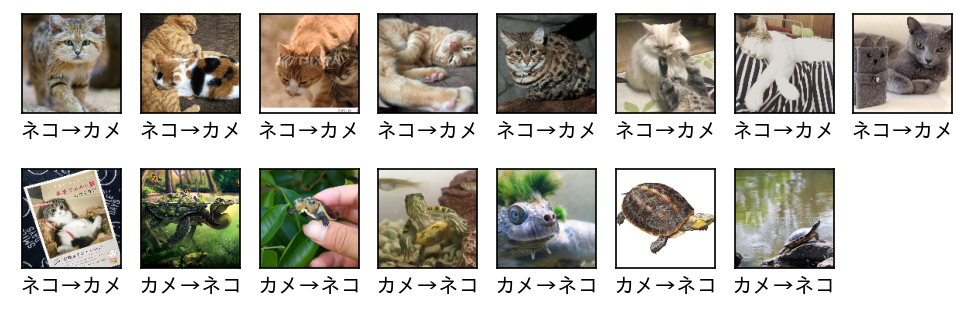

In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:カメ
else:
  print("誤認識はありません")

# ネコ，イヌ，カメ

## データの準備

In [ ]:
catnamelist = ['ネコ','イヌ','カメ']
CATALIST=[c0img,c1img,c2img] # c0img:ネコ, c1img:イヌ，c2img:カメ

# 訓練用とテスト用に分割
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

# データ数の確認
ntrain = len(Xtrain)
ntest  = len(Xtest)
print("カテゴリ数 {}   1カテゴリ当たりのデータ数 {}".format(len(CATALIST),NDATA))
print("訓練用 {} テスト用 {}  　データ総数 {}".format(ntrain,ntest,ntrain+ntest))

# 正解データの確認
print(ytrain,ytest)

カテゴリ数 3   1カテゴリ当たりのデータ数 81
訓練用 162 テスト用 81  　データ総数 243
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
# 変数の宣言
CLASSES= len(CATALIST)  #  カテゴリ数　ここでは　３　
DATASIZE = SIZE *  SIZE * 3

# Model 1
model1 = Sequential([
    Dense(CLASSES, activation='softmax', input_shape=(DATASIZE,))
])
model = model1
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 2], [6, 0, 2], [7, 0, 2], [8, 0, 2], [9, 0, 2], [10, 0, 2], [12, 0, 1], [18, 0, 1], [19, 0, 1], [20, 0, 2], [22, 0, 1], [26, 0, 2], [27, 0, 1], [29, 0, 1], [33, 0, 2], [34, 0, 2], [41, 0, 2], [44, 0, 2], [49, 0, 2], [51, 0, 2], [52, 0, 2], [53, 0, 2], [56, 1, 2], [57, 1, 2], [59, 1, 2], [65, 1, 2], [67, 1, 0], [68, 1, 2], [71, 1, 2], [72, 1, 2], [79, 1, 0], [80, 1, 2], [81, 1, 2], [88, 1, 2], [93, 1, 2], [95, 1, 2], [98, 1, 2], [101, 1, 2], [102, 1, 2], [106, 1, 2], [107, 1, 2], [121, 2, 1], [132, 2, 0], [142, 2, 1], [159, 2, 0]] 
　正解率= 72.2　誤り率＝ 27.8 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,32,6,16,59.3
イヌ,2,35,17,64.8
カメ,2,2,50,92.6


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model1, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 2], [1, 0, 1], [5, 0, 1], [7, 0, 2], [8, 0, 2], [9, 0, 2], [10, 0, 2], [12, 0, 2], [13, 0, 1], [15, 0, 2], [18, 0, 1], [19, 0, 2], [21, 0, 2], [22, 0, 2], [26, 0, 2], [28, 1, 0], [29, 1, 2], [30, 1, 0], [32, 1, 2], [33, 1, 0], [34, 1, 2], [36, 1, 2], [37, 1, 2], [39, 1, 2], [42, 1, 0], [43, 1, 0], [44, 1, 2], [45, 1, 2], [46, 1, 0], [47, 1, 2], [49, 1, 0], [50, 1, 0], [52, 1, 2], [60, 2, 0], [69, 2, 1], [72, 2, 0], [74, 2, 0]] 
　正解率= 54.3　誤り率＝ 45.7 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,12,4,11,44.4
イヌ,8,9,10,33.3
カメ,3,1,23,85.2


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# model2

In [ ]:
# Model 2

model2 = Sequential([
    Dense(1024,activation='relu',input_shape=(DATASIZE,)),
    Dense(CLASSES, activation='softmax')
])
model = model2
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).reshape(len(Xtrain),DATASIZE).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=5)   #  訓練用データのロスが改善されなくなったら2エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

## 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model2, Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[18, 0, 1], [19, 0, 1], [21, 0, 1], [23, 0, 1], [26, 0, 1], [27, 0, 1], [106, 1, 0], [108, 2, 1], [109, 2, 1], [111, 2, 0], [112, 2, 1], [114, 2, 1], [115, 2, 1], [116, 2, 1], [117, 2, 0], [118, 2, 1], [119, 2, 1], [120, 2, 0], [121, 2, 1], [122, 2, 1], [124, 2, 1], [125, 2, 1], [126, 2, 0], [128, 2, 1], [129, 2, 1], [130, 2, 1], [131, 2, 1], [133, 2, 1], [135, 2, 1], [136, 2, 1], [137, 2, 1], [138, 2, 1], [139, 2, 1], [140, 2, 1], [141, 2, 1], [142, 2, 1], [143, 2, 1], [146, 2, 1], [147, 2, 1], [148, 2, 1], [149, 2, 1], [150, 2, 1], [151, 2, 0], [153, 2, 1], [154, 2, 1], [155, 2, 1], [156, 2, 1], [157, 2, 1], [158, 2, 1], [159, 2, 0], [160, 2, 0]] 
　正解率= 68.5　誤り率＝ 31.5 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,48,6,0,88.9
イヌ,1,53,0,98.1
カメ,7,37,10,18.5


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
X = (np.array(Xtest).reshape(len(Xtest),DATASIZE).astype('float32'))/255
TestError, crossTable = recognitionResult(model2, Xdata=X, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [5, 0, 1], [8, 0, 1], [9, 0, 1], [10, 0, 1], [12, 0, 2], [13, 0, 1], [14, 0, 1], [15, 0, 2], [17, 0, 1], [18, 0, 1], [19, 0, 1], [26, 0, 1], [28, 1, 0], [30, 1, 0], [32, 1, 2], [33, 1, 0], [37, 1, 0], [39, 1, 2], [43, 1, 0], [46, 1, 0], [47, 1, 0], [49, 1, 0], [50, 1, 0], [54, 2, 0], [55, 2, 0], [57, 2, 1], [58, 2, 1], [59, 2, 0], [60, 2, 0], [61, 2, 1], [62, 2, 1], [63, 2, 1], [64, 2, 1], [65, 2, 0], [66, 2, 1], [67, 2, 0], [68, 2, 0], [69, 2, 1], [70, 2, 1], [71, 2, 1], [72, 2, 0], [74, 2, 0], [75, 2, 1], [76, 2, 1], [77, 2, 1], [79, 2, 1], [80, 2, 1]] 
　正解率= 39.5　誤り率＝ 60.5 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,13,12,2,48.1
イヌ,9,16,2,59.3
カメ,9,15,3,11.1


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# model3

In [ ]:
# Model ３

model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # 64 x 64 x 64
    Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  #  32 x 32 x 128
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(CLASSES, activation='softmax')
])
model = model3
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

# データを 浮動小数点数に変換し、[0,255] → [0,1] に変換
X = (np.array(Xtrain).astype('float32'))/255
y = np.array(ytrain).astype('float32')
es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

# 訓練データに対する識別実験結果

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model3,Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [] 
　正解率=100.0　誤り率＝  0.0 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,54,0,0,100.0
イヌ,0,54,0,100.0
カメ,0,0,54,100.0


In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

誤認識はありません


## テストデータに対する識別実験結果

In [ ]:
# テストデータでの識別結果
Xte = (np.array(Xtest).astype('float32'))/255
TestError, crossTable = recognitionResult(model3,Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[0, 0, 1], [1, 0, 1], [2, 0, 1], [3, 0, 1], [5, 0, 1], [8, 0, 2], [12, 0, 2], [13, 0, 1], [15, 0, 1], [18, 0, 1], [19, 0, 1], [20, 0, 1], [26, 0, 1], [28, 1, 0], [30, 1, 0], [32, 1, 0], [33, 1, 0], [34, 1, 2], [37, 1, 2], [39, 1, 2], [41, 1, 0], [42, 1, 0], [43, 1, 0], [47, 1, 2], [49, 1, 0], [50, 1, 2], [52, 1, 2], [64, 2, 0], [69, 2, 0], [72, 2, 0], [74, 2, 0], [79, 2, 0]] 
　正解率= 60.5　誤り率＝ 39.5 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,14,11,2,51.9
イヌ,8,13,6,48.1
カメ,5,0,22,81.5


In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
  # 0:ネコ、1:イヌ，2:カメ
else:
  print("誤認識はありません")

# 転移学習 (Transfer Lerning)

ある学習問題のモデルを０から作るのではなく、類似問題の学習済みモデルの一部を流用し、効率的に学習モデルを構築することを、**転移学習**(Transfer Learning)と言います。

ここでは、試しに、**MobileNetV2** と呼ばれる、モバイル向けの画像認識用の学習モデルを利用し、ImageNetと呼ばれる、一般物体認識のコンテストILSVRC用に学習された重みを使ってみます。

ちなみに、ImageNetで扱われるのは1000カテゴリの識別です。犬やネコもその中に含まれます。

- [Keras: ImageNet分類ラベル一覧](https://hazm.at/mox/machine-learning/computer-vision/classification/keras-pre-trained/vgg16/index.html)



In [ ]:
# MobileNetV2 の出力部分を除いたモデル定義を再利用し、重みは
mnmodel = keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False, 
                                               weights='imagenet')
# MobileNetV2 流用部分の構造確認
mnmodel.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

層の多さにびっくりするかもしれませんが、MobileNetV2 はモバイル用なので、これでも深層ネットワークとしてはコンパクトなはずです。

流用部分の最終段は、４ｘ４ｘ1,280チャネルで終わっています。４x４という小さな層が1280個あるわけですが、まず、この４x４の平均値をそれぞれ求めて1,280個に圧縮します。この操作を、**GlobalAveragePooling2D**)と言います。最後に出力層と全結合して終わりです。

これを具体的に書くと次のようになります。






In [ ]:
model4 = Sequential([
    mnmodel,
    GlobalAveragePooling2D(),
    Dense(CLASSES, activation='softmax')
])

model4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


今回、流用部分の重みは固定します。GlobalAveragePooling2Dは単に平均を取るだけなので、重みの調整はありません。学習、つまり、重みを調整するのは最終層のみということになるので、大変高速に処理できます。

今度は初めから、３カテゴリで試すことにします。

なお、**MobileNetV2**では入力は０～１ではなく、-1～＋１の範囲なので、６行目と１０行目で、そうなるように変換しています。

In [ ]:
catnamelist = ['ネコ','イヌ','カメ']
CATALIST = [c0img,c1img,c2img] # c0img:ネコ，c1img：イヌ, c2img：カメ
CLASSES = len(CATALIST)
Xtrain,ytrain,Xtest,ytest,NDATA = make_dataset(CATALIST) 

X = (np.array(Xtrain).astype('float32'))/127.5-1
# X = tf.image.resize(X, (160,160))
y = np.array(ytrain).astype('float32')

Xte = (np.array(Xtest).astype('float32'))/127.5-1
# Xte = tf.image.resize(Xte, (160,160))
yte = np.array(ytest).astype('float32')

model = model4
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

es = EarlyStopping(monitor='loss', patience=3)   #  訓練用データのロスが改善されなくなったら3エポック後に停止
tb_cb = TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X , y,
                 epochs=100,
                 verbose=1,
                 callbacks=[es, csv_logger])

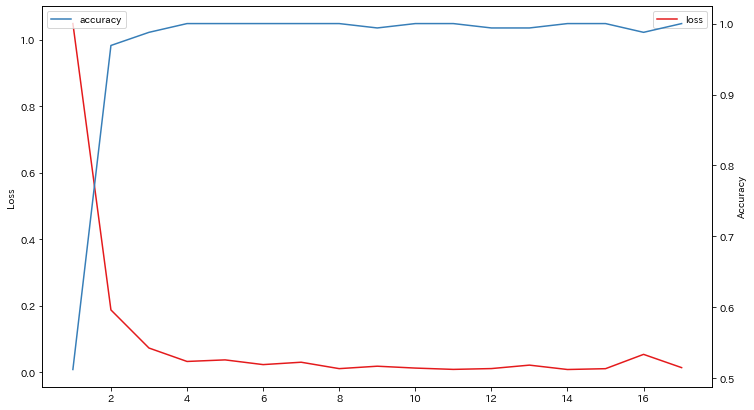

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
acc = hist.history['accuracy']
loss = hist.history['loss']
ax1.plot(range(1, len(loss)+1), loss,color=cm.Set1.colors[0],label='loss')
ax2.plot(range(1, len(acc)+1), acc,color=cm.Set1.colors[1],label='accuracy')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
# 訓練データに対する識別結果
TrainError, crossTable = recognitionResult(model4,Xdata=X, ydata=ytrain, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[133, 2, 1], [143, 2, 0]] 
　正解率= 98.8　誤り率＝  1.2 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,54,0,0,100.0
イヌ,0,54,0,100.0
カメ,1,1,52,96.3


誤認識したデータ


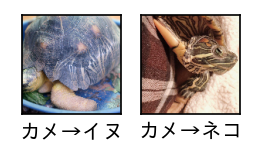

In [ ]:
# 誤認識した画像を表示
if len(TrainError)>0:
  print("誤認識したデータ")
  showEimg(TrainError,Xtrain)
else:
  print("誤認識はありません")

In [ ]:
# テストデータでの識別結果
TestError, crossTable = recognitionResult(model4,Xdata=Xte, ydata=ytest, catnamelist=catnamelist)
crossTable

誤認識データ（[データ番号, 正解, 認識結果]）
 [[6, 0, 1], [11, 0, 1], [35, 1, 0], [36, 1, 0], [44, 1, 0], [74, 2, 0], [76, 2, 0], [77, 2, 0]] 
　正解率= 90.1　誤り率＝  9.9 %

正解カテゴリに対する認識結果と正解率


,ネコ,イヌ,カメ,正解率
正解カテゴリ,,,,
ネコ,25,2,0,92.6
イヌ,3,24,0,88.9
カメ,3,0,24,88.9


誤認識したデータ


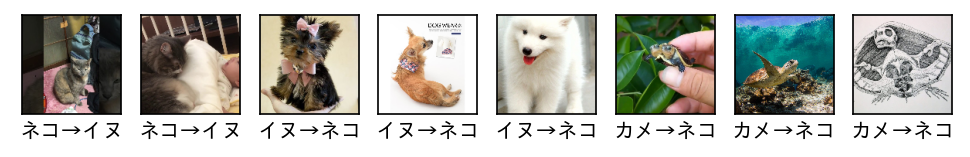

In [ ]:
# 誤認識した画像を表示
if len(TestError)>0:
  print("誤認識したデータ")
  showEimg(TestError,Xtest)
else:
  print("誤認識はありません")

# 課題

1. ４つ以上のカテゴリを使った識別実験を行ってください．その中にイヌとネコの片方，または両方を含めても構いません，含めなくても構いません．model1～model4のそれぞれについて，全データに対する正解率および，「正解カテゴリに対する認識結果と正解率」の表を記録して報告してください．なお，accuracy が 0.85 を超えずに学習が終了してしまったり，loss のグラフが激しく上下してしまった場合は実行をやり直してください．

2. 結果について考察してください．（例えば，他のカテゴリと比べて正解が多いカテゴリや逆に間違いが多いカテゴリなど，気づいたことや，その理由など．）

余裕があれば次のような追加実験をしましょう．

3. 同じ実験を何度か繰り返し，同じ傾向がみられるかどうか検証する．
4. もっとカテゴリを増やして実験してみる．
5. 画像サイズを変えて実験してみる．
6. 畳み込み層とプーリング層の数、チャネル数などを変えて実験してみる．